In [1]:
import math
import multiprocessing
import os
from copy import copy
from os.path import join

from multiprocessing import Pool
from itertools import repeat

import numpy as np
import pandas as pd
import scipy.ndimage
import skimage.color
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from tqdm.autonotebook import tqdm
from sklearn.metrics import confusion_matrix

/var/folders/bd/p184240n54q_jyxbctz28gkh0000gn/T/ipykernel_31423/1859191788.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 16-720 Computer Vision: Homework 1 (Spring 2022)
## Spatial Pyramid Matching for Scene Classification

In [2]:
class Opts(object):
    def __init__(
        self,
        data_dir="../data",
        feat_dir="../feat",
        out_dir=".",
        filter_scales=(1, 2, 4),
        K=70,
        alpha=50,
        L=3,
    ):
        '''
        Manage tunable hyperparameters.

        You can also add your own additional hyperparameters.

        [input]
        * data_dir: Data directory.
        * feat_dir: Feature directory.
        * out_dir: Output directory.
        * filter_scales: A list of scales for all the filters.
        * K: Number of words.
        * alpha: Subset of alpha pixels in each image.
        * L: Number of layers in spatial pyramid matching (SPM).

        '''
        self.data_dir = data_dir
        self.feat_dir = feat_dir
        self.out_dir = out_dir
        self.filter_scales = list(filter_scales)
        self.K = K
        self.alpha = alpha
        self.L = L

opts = Opts()

In [3]:
# utils

def get_num_CPU():
    '''
    Counts the number of CPUs available in the machine.
    '''
    return multiprocessing.cpu_count()


def display_filter_responses(opts, response_maps):
    '''
    Visualizes the filter response maps.

    [input]
    * response_maps: a numpy.ndarray of shape (H,W,3F)
    '''

    n_scale = len(opts.filter_scales)
    plt.figure()

    for i in range(n_scale * 4):
        plt.subplot(n_scale, 4, i + 1)
        resp = response_maps[:, :, i * 3:i * 3 + 3]
        resp_min = resp.min(axis=(0, 1), keepdims=True)
        resp_max = resp.max(axis=(0, 1), keepdims=True)
        resp = (resp - resp_min) / (resp_max - resp_min)
        plt.imshow(resp)
        plt.axis("off")

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95,
                        bottom=0.05, wspace=0.05, hspace=0.05)
    plt.show()


def visualize_wordmap(original_image, wordmap, out_path=None):
    fig = plt.figure(figsize=(12.8, 4.8))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(original_image)
    plt.axis("off")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(wordmap)
    plt.axis("off")
    plt.show()
    if out_path:
        plt.savefig(out_path, pad_inches=0)


## Question 1

## Q1.1.1



The Gaussian Filter blurs the image and also reduces noise.

The Laplacian of Gaussian Filter is used for edge detection.

The Derivative of Gaussian in the x direction is used for vertical feature detection.

The Derivative of Gaussian in the y direction is used for horizontal feature detection. 

## Q1.1.2

In [4]:
def extract_filter_responses(opts, img):
    '''
    Extracts the filter responses for the given image.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)
    [output]
    * filter_responses: numpy.ndarray of shape (H,W,3F)
    '''
    filter_scales = opts.filter_scales
    # ----- TODO -----
    lab_color_space = skimage.color.rgb2lab(img)
    img_shape = np.shape(img)
    H = img_shape[0]
    W = img_shape[1]
    F = 4*len(filter_scales)
    #grayscale to RGB
    if len(img_shape) < 3:
        img = np.hstack((img.shape,3))
    #3F dimension to RGB
    if img_shape[2] > 3:
        img = img[:,:,0:3]
    filter_responses = np.zeros((H,W,3*F))
    for i in range(len(filter_scales)):
        for j in range(3):
            #Gaussian
            filter_responses[:,:,(12*i)+j] = scipy.ndimage.gaussian_filter(lab_color_space[:,:,j], filter_scales[i])
            #Laplacian of Gaussian
            filter_responses[:,:,(12*i)+j+3] = scipy.ndimage.gaussian_laplace(lab_color_space[:,:,j], filter_scales[i])
            #derivative of Gaussian in x
            filter_responses[:,:,(12*i)+j+6] = scipy.ndimage.gaussian_filter(lab_color_space[:,:,j], filter_scales[i], [1,0])
            #derivative of Gaussian in y
            filter_responses[:,:,(12*i)+j+9] = scipy.ndimage.gaussian_filter(lab_color_space[:,:,j], filter_scales[i], [0,1])            
    return filter_responses

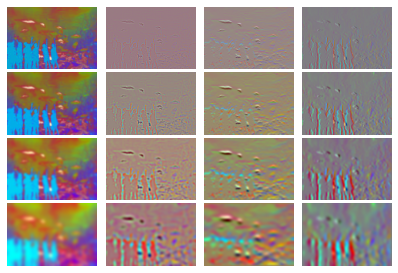

In [20]:
# Should have filters for at least 3 scales.
opts.filter_scales = [1, 2, 4, 8]
img_path = join(opts.data_dir, 'aquarium/sun_aztvjgubyrgvirup.jpg')
img = plt.imread(img_path) / 255.
filter_responses = extract_filter_responses(opts, img)
display_filter_responses(opts, filter_responses)

## Q1.2

In [6]:
def compute_dictionary_one_image(args):
    """
    Extracts a random subset of filter responses of an image and save it to disk
    This is a worker function called by compute_dictionary

    Your are free to make your own interface based on how you implement compute_dictionary
    """
    opts, idx, img_path, alpha = args
    # ----- TODO -----    

def compute_dictionary(opts, n_worker=8):
    """
    Creates the dictionary of visual words by clustering using k-means.

    [input]
    * opts         : options
    * n_worker     : number of workers to process in parallel

    [saved]
    * dictionary : numpy.ndarray of shape (K,3F)
    """

    data_dir = opts.data_dir
    feat_dir = opts.feat_dir
    out_dir = opts.out_dir
    K = opts.K
    alpha = opts.alpha

    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    # ----- TODO -----
    filter_scales = opts.filter_scales
#     #extract the responses:
    fr = np.empty((alpha*len(train_files),36))
    for a in range(len(train_files)):
        
        img_path = join(opts.data_dir, train_files[a])
        img_1 = plt.imread(img_path)/255.
        filter_responses = extract_filter_responses(opts, img_1)
        H = filter_responses.shape[0]
        W = filter_responses.shape[1]
        F = 4*len(filter_scales)
    
        pixels = np.empty((alpha,2))
        for i in range(alpha):
            idx_1 = np.random.randint(H)
            idx_2 = np.random.randint(W)
            pixels[i,0] = idx_1
            pixels[i,1] = idx_2
            
        for i in range(alpha):
            fr[i*a,:] = filter_responses[int(pixels[i,0]),int(pixels[i,1])]
         #run Kmeans
        if a%100 == 0:
            print("Iteration Number: ",a)
    kmeans = KMeans(n_clusters=K).fit(fr)
    dictionary = kmeans.cluster_centers_
    np.save("dictionary",dictionary)

In [7]:
n_cpu = get_num_CPU()
compute_dictionary(opts, n_worker=n_cpu)

Iteration Number:  0
Iteration Number:  100
Iteration Number:  200
Iteration Number:  300
Iteration Number:  400
Iteration Number:  500
Iteration Number:  600
Iteration Number:  700
Iteration Number:  800
Iteration Number:  900
Iteration Number:  1000
Iteration Number:  1100


## Q1.3

The wordmap shows the contours in each image. Words change along the edges and tend to stay the same for homogenous regions.

In [8]:
def get_visual_words(opts, img, dictionary):
    """
    Compute visual words mapping for the given img using the dictionary of visual words.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)

    [output]
    * wordmap: numpy.ndarray of shape (H,W)
    """

    # ----- TODO -----
    filter_responses = extract_filter_responses(opts, img)
    H = filter_responses.shape[0]
    W = filter_responses.shape[1]
    
    wordmap = np.empty((H,W))
    for i in range(H):
        for j in range(W):
            pixel_responses = filter_responses[i,j]
            euc_dist = scipy.spatial.distance.cdist(pixel_responses[:,None].T, dictionary,'euclidean')
            wordmap[i,j] = np.argmin(euc_dist)
    return wordmap



In [9]:
dictionary = np.load(join(opts.out_dir, 'dictionary.npy'))

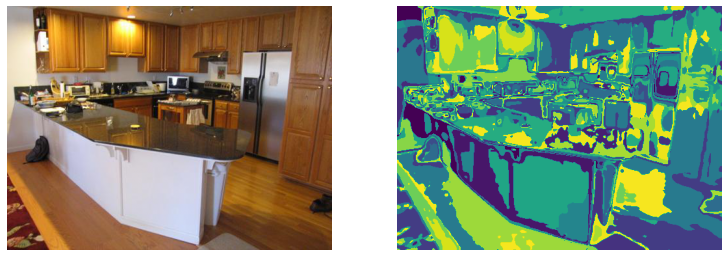

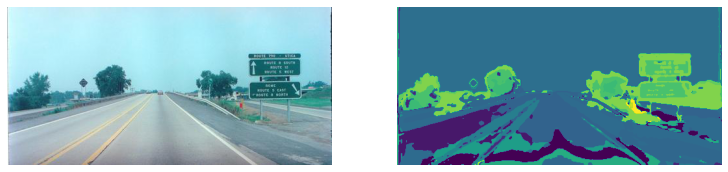

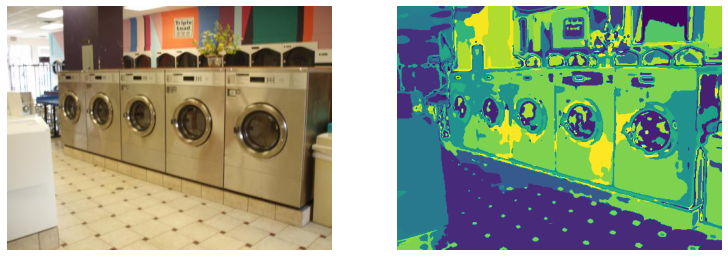

In [10]:
img_path = join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

img_path = join(opts.data_dir, 'highway/sun_ailjxpgyepocjdos.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

img_path = join(opts.data_dir, 'laundromat/sun_aabvooxzwmzzvwds.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)


## Q2.1

In [11]:
def get_feature_from_wordmap(opts, wordmap):
    '''
    Compute histogram of visual words.

    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)

    [output]
    * hist: numpy.ndarray of shape (K)
    '''

    K = opts.K
    # ----- TODO -----
    H = wordmap.shape[0]
    W = wordmap.shape[1]
    hist = np.histogram(wordmap,K,range=(0.,K-1),density=True)[0]
    return hist

## Q2.2



In [12]:
def get_feature_from_wordmap_SPM(opts, wordmap):
    """
    Compute histogram of visual words using spatial pyramid matching.

    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)

    [output]
    * hist_all: numpy.ndarray of shape (K*(4^L-1)/3)=10
    """
    K = opts.K
    L = opts.L 
    # ----- TODO -----
    H = wordmap.shape[0]
    W = wordmap.shape[1]
    w_hist = []
    for l in range(L+1):
        if l > 1:
            weight = 2**(l-L-1)
        else:
            weight = 2**(-L)
        w_hist.append(weight)
    w_hist = np.flip(w_hist) 
#     print("w_hist shape", np.shape(w_hist))
    hist_new = np.array([])
    
    
    for i in range(L+1):
        image_size = (2**L)-i
        patch_h = int(H/image_size)
        patch_w = int(W/image_size)
        layer = []
        for j in range(image_size):
            for g in range(image_size):
                cell = wordmap[(patch_h*g):((patch_h*g)+patch_h),(patch_w*j):((patch_w*j)+patch_w)]
                layer.append(cell)
        
#         print(np.shape(layer))
        for cell in layer:
#             print(cell)
            hist = np.histogram(cell,K,range=(0.,K-1))[0]*w_hist[i]
#             print(hist)
#             print("Hist_b4: ",hist.shape)
            hist_new = np.concatenate((hist_new,hist))
#             print("After",hist_new.shape)

    hist_all = (hist_new/hist_new.sum())
    return hist_all

## Q2.3

In [13]:
def distance_to_set(word_hist, histograms):
#     print("Word_Hist shape: ",word_hist.shape)
#     print("Histogram shape: ",histograms.shape)
    """
    Compute the distance between a histogram of visual words with all training image histograms.

    [input]
    * word_hist: numpy.ndarray of shape (K)
    * histograms: numpy.ndarray of shape (N,K)

    [output]
    * dists: numpy.ndarray of shape (N)
    """

    # ----- TODO -----
    dists = []
    intersection = np.minimum(histograms, word_hist)
    dists = np.sum(intersection,1)
    
#     for i in range(histograms.shape[0]):
#         h_current = histograms[i]
#         intersection = np.minimum(word_hist,h_current)
#         distance = np.sum(intersection)
#         dists.append(distance)
    return np.array(dists)

## Q2.4

In [14]:
def get_image_feature(opts, img_path, dictionary):
    """
    Extracts the spatial pyramid matching feature.

    [input]
    * opts      : options
    * img_path  : path of image file to read
    * dictionary: numpy.ndarray of shape (K, 3F)


    [output]
    * feature: numpy.ndarray of shape (K)
    """

    # ----- TODO -----
    img = plt.imread(img_path)/255.
    img = img[:,:,:3]
    wordmap = get_visual_words(opts,img,dictionary)
    feature = get_feature_from_wordmap_SPM(opts,wordmap)

    return feature



In [15]:
def build_recognition_system(opts, n_worker=8):
    """
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel

    [saved]
    * features: numpy.ndarray of shape (N,M)
    * labels: numpy.ndarray of shape (N)
    * dictionary: numpy.ndarray of shape (K,3F)
    * SPM_layer_num: number of spatial pyramid layers
    """

    data_dir = opts.data_dir
    out_dir = opts.out_dir
    SPM_layer_num = opts.L

    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    train_labels = np.loadtxt(join(data_dir, "train_labels.txt"), np.int32)
    dictionary = np.load(join(out_dir, "dictionary.npy"))
    # ----- TODO -----
    feature = []
    a = 0
    for img_path in train_files:
        a +=1
#         print(img_path)
        img_path = join(opts.data_dir, img_path)
        features = get_image_feature(opts,img_path,dictionary)
#         print("features shape", features.shape)
        feature.append(features)
        if a%100 == 0:
            print("Iteration Number: ",a)
#     print(feature.shape)
    # example code snippet to save the learned system
    np.savez_compressed(join(out_dir, 'trained_system.npz'),
        features=np.array(feature),
        labels=train_labels,
        dictionary=dictionary,
        SPM_layer_num=SPM_layer_num,
    )


In [16]:
build_recognition_system(opts, n_worker=n_cpu)

Iteration Number:  100
Iteration Number:  200
Iteration Number:  300
Iteration Number:  400
Iteration Number:  500
Iteration Number:  600
Iteration Number:  700
Iteration Number:  800
Iteration Number:  900
Iteration Number:  1000
Iteration Number:  1100


## Q2.5

In [17]:
def evaluate_recognition_system(opts, n_worker=8):
    """
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    """

    data_dir = opts.data_dir
    out_dir = opts.out_dir

    trained_system = np.load(join(out_dir, "trained_system.npz"))
    dictionary = trained_system["dictionary"]
#     print(np.shape(dictionary))
    # using the stored options in the trained system instead of opts.py
    test_opts = copy(opts)
    test_opts.K = dictionary.shape[0]
    test_opts.L = trained_system["SPM_layer_num"]

    test_files = open(join(data_dir, "test_files.txt")).read().splitlines()
    test_labels = np.loadtxt(join(data_dir, "test_labels.txt"), np.int32)

#     print("Length of test files: ",len(test_files))
    
    # ----- TODO -----
    conf = np.zeros((8,8))
    feature_label = trained_system["features"]
#     print("Feature Label shape: ",feature_label.shape)
    training_labels = trained_system["labels"]
#     print("Training Labels size",training_labels.shape)
    
    for i in range(len(test_files)):
#         if test_labels[i] == 0:
#             continue
        file_path = os.path.join(data_dir,test_files[i])
        feat = get_image_feature(opts,file_path,dictionary)
#         print("Feat shape: ",np.shape(feat))
        
        dist = distance_to_set(feat,feature_label)
#         print(np.shape(dist))
        
        #Predicted Label for every i:
        label_pred = int(training_labels[np.argmax(dist)])
#         print("Predicted Label: ",label_pred)
        
        
        #Actual Label for every i:
        label_actual = test_labels[i]
#         print("Actual Label: ",label_actual)
        
        #Confusion Matrix
        conf[label_actual,label_pred] += 1
        
        if i%10 ==0:
            print("Number of Iterations: ",i)
    accuracy = (np.trace(conf)/np.sum(conf))*100
    return conf, accuracy

In [18]:
conf, accuracy = evaluate_recognition_system(opts, n_worker=8)
# print(conf)
print("Accuracy:", accuracy)
classes = [
    "aquarium", "desert", "highway", "kitchen",
    "laundromat", "park", "waterfall", "windmill",
]
df = pd.DataFrame(conf, columns=classes)
df.insert(0, "", classes)
df

Number of Iterations:  0
Number of Iterations:  10
Number of Iterations:  20
Number of Iterations:  30
Number of Iterations:  40
Number of Iterations:  50
Number of Iterations:  60
Number of Iterations:  70
Number of Iterations:  80
Number of Iterations:  90
Number of Iterations:  100
Number of Iterations:  110
Number of Iterations:  120
Number of Iterations:  130
Number of Iterations:  140
Number of Iterations:  150
Number of Iterations:  160
Number of Iterations:  170
Number of Iterations:  180
Number of Iterations:  190
Number of Iterations:  200
Number of Iterations:  210
Number of Iterations:  220
Number of Iterations:  230
Number of Iterations:  240
Number of Iterations:  250
Number of Iterations:  260
Number of Iterations:  270
Number of Iterations:  280
Number of Iterations:  290
Number of Iterations:  300
Number of Iterations:  310
Number of Iterations:  320
Number of Iterations:  330
Number of Iterations:  340
Number of Iterations:  350
Number of Iterations:  360
Number of It

,,aquarium,desert,highway,kitchen,laundromat,park,waterfall,windmill
0,aquarium,36.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0
1,desert,0.0,36.0,4.0,2.0,2.0,1.0,1.0,4.0
2,highway,1.0,6.0,27.0,0.0,0.0,2.0,2.0,12.0
3,kitchen,1.0,4.0,1.0,33.0,5.0,0.0,2.0,4.0
4,laundromat,0.0,6.0,3.0,5.0,28.0,5.0,3.0,0.0
5,park,1.0,2.0,3.0,0.0,2.0,36.0,3.0,3.0
6,waterfall,3.0,0.0,3.0,0.0,2.0,6.0,33.0,3.0
7,windmill,0.0,4.0,12.0,1.0,0.0,1.0,0.0,32.0


## Q2.6



Based off the confusion matrix, it seems like kitchen got classified as the laundromat the most and desert got classified as highway the most since there is a signifcant overlap in the color maps of these images.

## Q3.1



## Find optimal K, with constant L, alpha

#### From L = 1, K = 10, alpha = 25 ------> L = 1, K = 40, alpha = 25
Accuracy = 59.5%

#### From L = 1, K = 10, alpha = 25 ------> L = 1, K = 35, alpha = 25
Accuracy = 60%

#### From L = 1, K = 10, alpha = 25 ------> L = 1, K = 30, alpha = 25
Accuracy = 61.25%

#### From L = 1, K = 10, alpha = 25 ------> L = 1, K = 20, alpha = 25
Accuracy = 61.75%


## Find Optimal L, with constant K, alpha
#### From L = 1, K = 10, alpha = 25 -------> L = 4, K = 10, alpha = 25
Accuracy = 51%

#### From L = 1, K = 10, alpha = 25 -------> L = 3, K = 10, alpha = 25
Accuracy = 56.75%

#### From L = 1, K = 10, alpha = 25 -------> L = 2, K = 10, alpha = 25
Accuracy = 54.25%

#### From L = 1, K = 10, alpha = 25 -------> L = 1, K = 10, alpha = 25
Accuracy = 53%


## Optimal K, L and Alpha = 50

#### From L = 1, K = 10, alpha = 25 ------->L=1, K = 25, alpha = 50
Accuracy = 60%

#### From L = 1, K = 10, alpha = 25 ------->L = 3 , K = 30 , alpha = 50
Accuracy = 63.2499%

#### From L = 1, K = 10, alpha = 25 ------->L = 3 , K = 20 , alpha = 50
Accuracy = 62.25%

### From L = 1, K = 10, alpha = alpha = 25 ------->L = 3 , K = 70 , alpha = 50, filter scales = [1,2,4]
Accuracy = 65.25%


## Q3.2



I tried to implement multiprocessing using starmap (A suggestion one of my friends in my lab who took this course last year gave me). I did some more research on the following websites:
1) https://stackoverflow.com/questions/43071440/multiprocessing-in-python-work-with-several-files

2) https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool.starmap

3) https://stackoverflow.com/questions/5442910/how-to-use-multiprocessing-pool-map-with-multiple-arguments


I expected this to speed up and reduce the computation time for the build_recognition_system as well as the evaluate_recognition_system functions.I hence implemented the starmap function on line 148 in the visual_recog.py file (separate from the jupyter-notebook environment on which I did most of this assignment)

However, I was unable to run the multiprocessing module due to some directory related issues which I was unable to resolve, specifically (IsADirectoryError: [Errno 21] Is a directory: '.') 


## Q3.3 (Extra Credit)

In [19]:
def compute_IDF(opts, n_worker=1):
    # YOUR CODE HERE
    pass

def evaluate_recognition_System_IDF(opts, n_worker=1):
    # YOUR CODE HERE
    pass

## REFERENCES

1) https://stackoverflow.com/questions/43071440/multiprocessing-in-python-work-with-several-files

2) https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool.starmap

3) https://stackoverflow.com/questions/5442910/how-to-use-multiprocessing-pool-map-with-multiple-arguments

4) https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

5) My friend Filip Nowicki helped me debug my code